# Relationships between demand and generation

In [1]:
import xarray as xr
import numpy as np

from scipy.stats import pearsonr, spearmanr
import geopandas

import string
letters = list(string.ascii_lowercase)

import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symbol: freexl_open_ods
/opt/conda/analysis3-26.01/lib/gdalplugins/.././libspatialite.so.8: undefined symb

In [2]:
%cd /g/data/w42/dr6273/work/seasonal_energy/
import functions as fn

/g/data/w42/dr6273/work/seasonal_energy


In [3]:
%load_ext autoreload
%autoreload 2

# Load data

#### Generation and demand

In [4]:
def anomalise_monthly(da, dims=["time"], period=None):
    """
    Anomalise monthly with respect to period (a slice object)
    """
    if period == None:
        return da.groupby("time.month").apply(lambda x: x - x.mean(dims))
    else:
        return da.sel({"time": period}).groupby("time.month").apply(lambda x: x - x.mean(dims))

Demand

In [5]:
demand_current = fn.load_monthly("demand_state_training2010-16_extrapolate1940-2023")["demand"]

In [6]:
demand_SC30 = fn.load_monthly("demand_state_step_change_2029-30_training2010-16_extrapolate1940-2023")["demand"]

In [7]:
demand_SC40 = fn.load_monthly("demand_state_step_change_2039-40_training2010-16_extrapolate1940-2023")["demand"]

In [8]:
demand_SC50 = fn.load_monthly("demand_state_step_change_2049-50_training2010-16_extrapolate1940-2023")["demand"]

In [9]:
aemo_demand = fn.load_monthly("aemo_demand_2010-19_detrended")["demand_stl"]

Current capacities

In [10]:
wind_current = fn.load_monthly("wind_power_REZ_current_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [11]:
solar_current = fn.load_monthly("solar_power_REZ_current_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [12]:
shortfall_current = fn.load_monthly("shortfall_REZ_current_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

Future capacities

In [13]:
wind_SC30 = fn.load_monthly("wind_power_REZ_step_change_2029-30_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [14]:
solar_SC30 = fn.load_monthly("solar_power_REZ_step_change_2029-30_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [15]:
shortfall_SC30 = fn.load_monthly("shortfall_REZ_step_change_2029-30_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

In [16]:
wind_SC40 = fn.load_monthly("wind_power_REZ_step_change_2039-40_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [17]:
solar_SC40 = fn.load_monthly("solar_power_REZ_step_change_2039-40_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [18]:
shortfall_SC40 = fn.load_monthly("shortfall_REZ_step_change_2039-40_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

In [19]:
wind_SC50 = fn.load_monthly("wind_power_REZ_step_change_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [20]:
solar_SC50 = fn.load_monthly("solar_power_REZ_step_change_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [21]:
shortfall_SC50 = fn.load_monthly("shortfall_REZ_step_change_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

# Correlation between demand and generation

In [22]:
def correlate_regions(ds1, ds2, var1, var2):
    """
    Return 2d dataset of spearman correlations and pvalues between each region in ds1 and ds2
    
    ds1, ds2: arrays to correlate
    var1, var2: str, names of variables to be used as dimensions in returned array
    """
    regions = ds1.region.values
    n_regions = len(regions)
    
    # Empty array
    cor_arr = np.full((n_regions, n_regions), np.nan)
    pval_arr = np.full((n_regions, n_regions), np.nan)
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            x = ds1.sel(region=r1)
            y = ds2.sel(region=r2)
            cor, pval = spearmanr(x, y)
            cor_arr[i, j] = cor
            pval_arr[i, j] = pval
            
    cor_ds = xr.DataArray(
        cor_arr,
        dims=[var1, var2],
        coords={var1: regions, var2: regions}
    ).to_dataset(name="cor")
    
    pval_ds = xr.DataArray(
        pval_arr,
        dims=[var1, var2],
        coords={var1: regions, var2: regions}
    ).to_dataset(name="pval")
    
    return cor_ds.merge(pval_ds)

In [23]:
def plot_cor(ax, ds, plot_pval=True, remove_lower=False, remove_diag=False, vmax=1, cmap="PiYG"):
    """
    Plot cross-correlation
    
    ax: axes to plot onto
    ds: array of correlation scores
    plot_pval: bool, whether to add significant results as marker
    remove_lower: bool, whether to plot lower triangle.
    remove_lower: bool, whether to plot diagonal.
    vmax: float, maximum value to plot for colormap
    cmap: matplotlib colormap, default 'RdBu'
    """
    x_name = ds["cor"].dims[0]
    y_name = ds["cor"].dims[1]
    
    x_len = len(ds[x_name])
    y_len = len(ds[y_name])
    
    ds2 = ds.copy()
    ds2 = ds2.assign_coords({
        x_name: range(x_len),
        y_name: range(y_len)
    })
    
    vmin = -1 * vmax
    
    m = ds2["cor"].transpose().values
    if remove_lower:
        m[np.tril_indices(m.shape[0], -1)] = np.nan
    if remove_diag:
        np.fill_diagonal(m, np.nan)

    # print(np.round(m, 2))
    # print(np.round(pval, 2))

    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(color='gray')    
    
    p = ax.pcolormesh(m, cmap=cmap, vmin=vmin, vmax=vmax)
    
    if plot_pval:
        pval = ds2["pval"].transpose().values
        
        if remove_lower:
            pval[np.tril_indices(pval.shape[0], -1)] = np.nan
        if remove_diag:
            np.fill_diagonal(pval, np.nan)
            
        pval = pval < 0.05

        for x in range(pval.shape[0]):
            for y in range(pval.shape[1]):
                if pval[x,y]:
                    ax.scatter(y+0.5, x+0.5, c="k", s=10, ec="white", lw=0.5)
    
    ax.set_xticks(np.arange(0.5, x_len, 1))
    ax.set_xticklabels(ds["cor"][x_name].values, rotation=70, fontsize=9)
    ax.set_xlabel(x_name)
    
    ax.set_yticks(np.arange(0.5, y_len, 1))
    ax.set_yticklabels(ds["cor"][y_name].values, fontsize=9)
    ax.set_ylabel(y_name)
    
    return p

In [24]:
def panel_cor(
    ds1_list, ds2_list, var1, var2, vmax_c=0.6,
    ds_list_names=["Current", "2030 - current", "2040 - 2030", "2050 - 2040"],
    months=[1, 4, 7, 10], remove_lower=False, savefig=False, filename=None
):
    """
    Plot correlation between two variables, and difference in correlation of those variables for
    future scenarios.
    
    ds1_list, ds2_list: list of datasets to correlate and calculte correlation differences
    var1, var2: str, names of ds1 and ds2
    vmax_c: float, colorbar maximum values for correlation
    ds_list_names: list of str, names of scenarios
    months: list of int, months to subset. len(months) should equal 4.
    remove_lower: bool, whether to hide lower triangle of correlation plot
    savefig: bool, whether to save figure or not
    filename: str, filename for saved figure
    """
    def _get_cor(d1, d2, m, v1=var1, v2=var2):
        _d1 = fn.sel_month(d1, m)
        _d2 = fn.sel_month(d2, m)
        return correlate_regions(_d1, _d2, v1, v2)
        
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    plot_letters = np.array(letters[:16]).reshape((4,4))
        
    fig, ax = plt.subplots(4, 4, figsize=(7,5))

    for i, month in enumerate(months):
        m_name = month_names[month-1]
        
        # Compute correlations and p-values
        c1 = _get_cor(ds1_list[0], ds2_list[0], month)
        c2 = _get_cor(ds1_list[1], ds2_list[1], month)
        c3 = _get_cor(ds1_list[2], ds2_list[2], month)
        c4 = _get_cor(ds1_list[3], ds2_list[3], month)
        
        print(np.nanmax(abs(c1["cor"].values[c1["cor"].values < 1])))
        print(np.nanmax(abs(c2["cor"].values[c2["cor"].values < 1])))
        print(np.nanmax(abs(c3["cor"].values[c3["cor"].values < 1])))
        print(np.nanmax(abs(c4["cor"].values[c4["cor"].values < 1])))
        print()

        # Correlation
        p1 = plot_cor(ax[i,0], c1, remove_lower=True, remove_diag=True, vmax=vmax_c)
        p2 = plot_cor(ax[i,1], c2, remove_lower=True, remove_diag=True, vmax=vmax_c)
        p3 = plot_cor(ax[i,2], c3, remove_lower=True, remove_diag=True, vmax=vmax_c)
        p4 = plot_cor(ax[i,3], c4, remove_lower=False, remove_diag=False, vmax=vmax_c)
        
        if i == 0:
            for j in range(4):
                ax[i,j].set_title(ds_list_names[j], loc="center", fontsize=10, y=1.08)
            
        ax[i,0].set_ylabel(m_name + "\n" + ds_list_names[0])
        for j in range(1, 4):
            ax[i,j].set_ylabel(ds_list_names[j])
            ax[i,j].set_yticks([])
        ax[i,3].set_ylabel("Solar")
            
        if i == 3:
            for j in range(3):
                ax[i,j].set_xlabel(ds_list_names[j])
            ax[i,3].set_xlabel("Wind")
        else:
            for j in range(4):
                ax[i,j].set_xlabel("")
                ax[i,j].set_xticks([])
        
        for j in range(4):
            ax[i,j].text(0.5, 6.55, plot_letters[i,j], fontsize=8, va="center", ha="center")#, weight="bold")
            
    cax = fig.add_axes([0.13, -0.08, 0.3, 0.015])
    cbar = fig.colorbar(p1, cax=cax, ticks=[-vmax_c, -vmax_c/2, 0, vmax_c/2, vmax_c], orientation="horizontal")
    cbar.ax.set_xlabel(r"Spearman $\rho$ [-]")

    # pval legend   
    col1 = Line2D([0], [0], marker='o', linestyle="", color="k", markeredgecolor="white", markersize=5, markeredgewidth=1)
    labels = [r"$p<0.05$"]
    
    plt.subplots_adjust(wspace=0.3)

    ax[-1,1].legend(
        [col1],
        labels,
        loc=(1, -1.3),
        # loc=(0.7, -2),
        ncol=1,
        frameon=False
    )
    
    if savefig:
        plt.savefig("figures/" + filename + ".pdf", format="pdf", bbox_inches="tight")

0.9999999999999999
0.9999999999999999
0.9999999999999999
0.21869358968976949

0.9999999999999999
0.9999999999999999
0.9999999999999999
0.3898241047814953

0.9999999999999999
0.9999999999999999
0.9999999999999999
0.4226312917173922

0.9999999999999999
0.9999999999999999
0.9999999999999999
0.3922589311951639



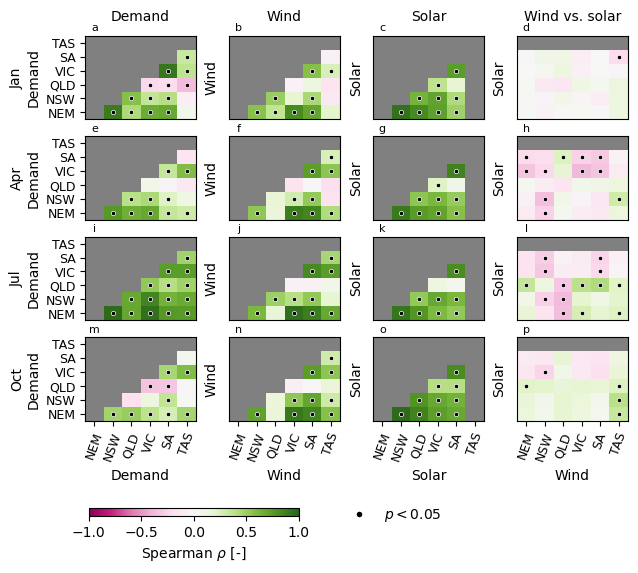

In [327]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    panel_cor(
        [demand_current, wind_current, solar_current, wind_current],
        [demand_current, wind_current, solar_current, solar_current],
        "X",
        "Y",
        vmax_c=1,
        ds_list_names=["Demand", "Wind", "Solar", "Wind vs. solar"],
        savefig=True,
        filename="correlation_gen_load"
    )

In [29]:
def plot_cor_diff(ds1_list, ds2_list, var1, var2, vmax_c=0.8, vmax_diff=0.4,
                  ds_list_names=["Current", "2030 - current", "2040 - 2030", "2050 - 2040"],
                  months=[1, 4, 7, 10], remove_lower=False, savefig=False, filename=None):
    """
    Plot correlation between two variables, and difference in correlation of those variables for
    future scenarios.
    
    ds1_list, ds2_list: list of datasets to correlate and calculte correlation differences
    var1, var2: str, names of ds1 and ds2
    vmax_c, vmax_diff: float, colorbar maximum values for correlation and correlation differences, respectively
    ds_list_names: list of str, names of scenarios
    months: list of int, months to subset. len(months) should equal 4.
    remove_lower: bool, whether to hide lower triangle of correlation plot
    savefig: bool, whether to save figure or not
    filename: str, filename for saved figure
    """
    def _get_cor(d1, d2, m, v1=var1, v2=var2):
        _d1 = fn.sel_month(d1, m)
        _d2 = fn.sel_month(d2, m)
        return correlate_regions(_d1, _d2, v1, v2)
    
    def _plot_sign(axis, d1, d2, baseline=None, v1=var1, v2=var2):
        """
        Plot marker if sign change between d1 and d2, given baseline condition.

        d1, d2: datasets
        baseline: dataset used to threshold sign changes, default None
        v1, v2: str, dim names
        """
        sign = np.sign(d2) - np.sign(d1) # sign change
        for x, r in enumerate(sign[v1]):
            for y, r2 in enumerate(sign[v2]):
                if (sign.sel({v1: r, v2: r2}).values != 0) & (~np.isnan(sign.sel({v1: r, v2: r2}))):
                    if baseline is None: # if no baseline, mark every case of sign change
                        axis.scatter(x+0.5, y+0.5, c="k", s=10, ec="white", lw=0.5)
                    else:
                        baseline_val = baseline.sel({v1: r, v2: r2}).values
                        if np.abs(baseline_val) > 0.25: # if sign change for baseline value, |v|>0.25, don't mark
                            axis.scatter(x+0.5, y+0.5, c="k", s=10, ec="white", lw=0.5)
                        else:
                            axis.scatter(x+0.5, y+0.5, c="white", s=10, ec="k", lw=0.5)
        
    month_names = ["January", "Feb", "Mar", "April", "May", "Jun", "July", "Aug", "Sep", "October", "Nov", "Dec"]
    cdiff_vmax = 0.3
    plot_letters = np.array(letters[:16]).reshape((4,4))
        
    fig, ax = plt.subplots(4, 4, figsize=(5,4))

    for i, month in enumerate(months):
        m_name = month_names[month-1]
        
        # Compute correlations
        c1 = _get_cor(ds1_list[0], ds2_list[0], month)
        c2 = _get_cor(ds1_list[1], ds2_list[1], month)
        c3 = _get_cor(ds1_list[2], ds2_list[2], month)
        c4 = _get_cor(ds1_list[3], ds2_list[3], month)
        
        # Differences
        cdiff_1 = (c2["cor"] - c1["cor"]).to_dataset(name="cor")
        cdiff_2 = (c3["cor"] - c2["cor"]).to_dataset(name="cor")
        cdiff_3 = (c4["cor"] - c3["cor"]).to_dataset(name="cor")
        
        print(np.nanmax(abs(c1["cor"].values)))
        # vmax_c = 0.6
        
        cdiff_max = np.nanmax([
            np.nanmax(abs(cdiff_1["cor"].values)),
            np.nanmax(abs(cdiff_2["cor"].values)),
            np.nanmax(abs(cdiff_3["cor"].values))
        ])
        print(cdiff_max)
        # vmax_diff = 0.3
        print()
              
        # Correlation (current)
        p1 = plot_cor(ax[i,0], c1, remove_lower=remove_lower, vmax=vmax_c)
        # Difference in correlation between successive scenarios
        p2 = plot_cor(ax[i,1], cdiff_1, plot_pval=False, remove_lower=remove_lower, vmax=vmax_diff, cmap="RdBu")
        p3 = plot_cor(ax[i,2], cdiff_2, plot_pval=False, remove_lower=remove_lower, vmax=vmax_diff, cmap="RdBu")
        p4 = plot_cor(ax[i,3], cdiff_3, plot_pval=False, remove_lower=remove_lower, vmax=vmax_diff, cmap="RdBu")
        
        # Change in sign between current and future scenarios
        _plot_sign(ax[i,1], c1["cor"], c2["cor"], baseline=c1["cor"])
        _plot_sign(ax[i,2], c2["cor"], c3["cor"], baseline=c1["cor"])
        _plot_sign(ax[i,3], c3["cor"], c4["cor"], baseline=c1["cor"])
        
        if i == 0:
            for j in range(4):
                ax[i,j].set_title(ds_list_names[j], loc="center", fontsize=10, y=1.05)
            
        ax[i,0].set_ylabel(m_name + "\n" + var2)
        for j in range(1, 4):
            ax[i,j].set_ylabel("")
            ax[i,j].set_yticks([])
            
        if i == 3:
            for j in range(4):
                ax[i,j].set_xlabel(var1)
        else:
            for j in range(4):
                ax[i,j].set_xlabel("")
                ax[i,j].set_xticks([])
        
        for j in range(4):
            ax[i,j].text(0.5, 6.55, plot_letters[i,j], fontsize=8, va="center", ha="center")#, weight="bold")
            
    # cax = fig.add_axes([0.13, -0.1, 0.15, 0.015])
    cax = fig.add_axes([0.01, -0.1, 0.3, 0.015])
    cbar = fig.colorbar(p1, cax=cax, ticks=[-vmax_c, -vmax_c/2, 0, vmax_c/2, vmax_c], orientation="horizontal")
    cbar.ax.set_xlabel(r"Spearman $\rho$ [-]")
    
    # cax2 = fig.add_axes([0.45, -0.1, 0.15, 0.015])
    cax2 = fig.add_axes([0.4, -0.1, 0.3, 0.015])
    cbar2 = fig.colorbar(p2, cax=cax2, ticks=[-vmax_diff, -vmax_diff/2, 0, vmax_diff/2, vmax_diff], orientation="horizontal")
    cbar2.ax.set_xlabel(r"Spearman $\rho$ difference [-]")
    
    # sign change and pval legend
    col1 = Line2D([0], [0], marker='o', linestyle="", color="k", markeredgecolor="white", markersize=5, markeredgewidth=0.5)
    col2 = Line2D([0], [0], marker='o', linestyle="", color="white", markeredgecolor="k", markersize=5, markeredgewidth=0.5)
    labels = [r"$p<0.05$", "Sign change"]

    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    
    ax[-1,2].legend(
        [col1, col2],
        labels,
        loc=(1.1, -1.75),
        # loc=(0.7, -2),
        ncol=1,
        frameon=False
    )
    
    if savefig:
        plt.savefig("figures/" + filename + ".pdf", format="pdf", bbox_inches="tight")

0.5633264766382603
0.1901053692120398

0.35244112337853156
0.16552621636371267

0.6779732169094497
0.1493010369002141

0.5342135090886192
0.2173712270685529



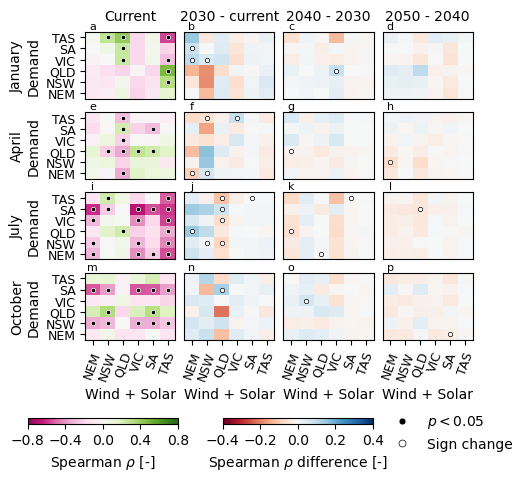

In [31]:
plot_cor_diff(
    [wind_current + solar_current, wind_SC30 + solar_SC30, wind_SC40 + solar_SC40, wind_SC50 + solar_SC50],
    [demand_current, demand_SC30, demand_SC40, demand_SC50],
    "Wind + Solar",
    "Demand",
    savefig=True,
    filename="correlation_change_gen_load"
)

0.21869358968976949
0.11223290374039713

0.3898241047814953
0.1714453633348726

0.4226312917173922
0.14470425255027075

0.3922589311951639
0.13232022165316315



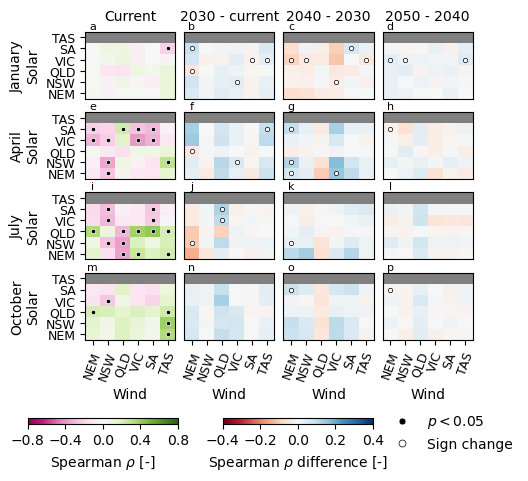

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    plot_cor_diff(
        [wind_current, wind_SC30, wind_SC40, wind_SC50],
        [solar_current, solar_SC30, solar_SC40, solar_SC50],
        "Wind",
        "Solar",
    savefig=False,
    filename="correlation_change_wind_solar"
    )

0.9999999999999999
0.33991016330128876

0.9999999999999999
0.28756139540741366

0.9999999999999999
0.20981486923302972

0.9999999999999999
0.22857982452457912



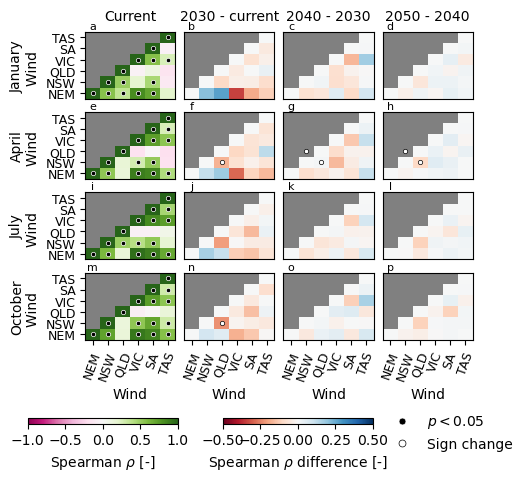

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    plot_cor_diff(
        [wind_current, wind_SC30, wind_SC40, wind_SC50],
        [wind_current, wind_SC30, wind_SC40, wind_SC50],
        "Wind",
        "Wind ",
        vmax_c=1,
        vmax_diff=0.5,
        remove_lower=True,
        savefig=False,
        # filename="correlation_change_wind_solar"
    )

0.9999999999999999
0.12371436967381721

0.9999999999999999
0.14774778556735646

0.9999999999999999
0.1821292137189875

0.9999999999999999
0.116158011838294



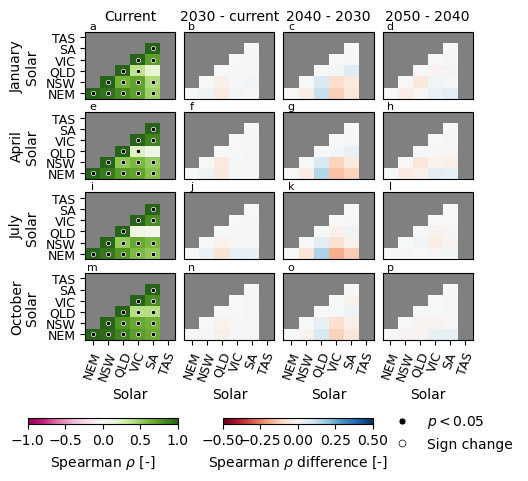

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    plot_cor_diff(
        [solar_current, solar_SC30, solar_SC40, solar_SC50],
        [solar_current, solar_SC30, solar_SC40, solar_SC50],
        "Solar",
        "Solar ",
        vmax_c=1,
        vmax_diff=0.5,
        remove_lower=True,
        savefig=False,
        # filename="correlation_change_wind_solar"
    )

### Correlation between residual load and demand, wind and solar

In [23]:
def correlate_shortfall_components(da1_list, da2_list, da3_list, da4_list, r):
    """
    Compute Spearman correlation coefficients between shortfall and its components for each scenario.
    
    da1 list will be correlated with da2, da3 and da2 + da3.
    
    da1_list, da2_list, da3_list, da4_list: list, each of 4 arrays (i.e. for each scenario year)
    r: str, region
    """
    sh_cor_dem = []
    sh_cor_wind = []
    sh_cor_sol = []
    sh_cor_gen = []
    for da1, da2, da3, da4 in zip(da1_list, da2_list, da3_list, da4_list):
    #     [shortfall_current, shortfall_SC30, shortfall_SC40, shortfall_SC50],
    #     [demand_current, demand_SC30, demand_SC40, demand_SC50],
    #     [wind_current, wind_SC30, wind_SC40, wind_SC50],
    #     [solar_current, solar_SC30, solar_SC40, solar_SC50]
    # ):
        sh_cor_dem.append(spearmanr(da1.sel(region=r), da2.sel(region=r))[0])
        sh_cor_wind.append(spearmanr(da1.sel(region=r), da3.sel(region=r))[0])
        sh_cor_sol.append(spearmanr(da1.sel(region=r), da4.sel(region=r))[0])
        sh_cor_gen.append(spearmanr(da1.sel(region=r), da3.sel(region=r) + da4.sel(region=r))[0])
        
    return [sh_cor_dem, sh_cor_wind, sh_cor_sol, sh_cor_gen]

In [26]:
def plot_shortfall_corr(ax, correlation_list, r, abs_cor=False):
    """
    Plot correlations between shortfall and its components
    
    ax: axes object
    correlation_list: list, correlation values
    r: str, region
    abs_cor: bool, whether to plot the absolute value of the correlation
    """
    if abs_cor:
        neg_marker = [[True if i >=0 else False for i in cor] for cor in correlation_list]
        correlation_list = [np.abs(i) for i in correlation_list]
    else:
        neg_marker = [[False for i in cor] for cor in correlation_list]
        
    s = 20
    lw = 1
        
    ax.plot(range(4), correlation_list[0], color="tab:gray", ls="-", lw=lw)
    for i in range(4):
        if neg_marker[0][i]:
            ax.scatter(
                i, correlation_list[0][i], marker="o", edgecolor="tab:gray", facecolor="tab:gray", s=s
            )
        else:
            ax.scatter(
                i, correlation_list[0][i], marker="o", edgecolor="tab:gray", facecolor="tab:gray", s=s
            )

    ax.plot(range(4), correlation_list[1], color="tab:green", ls="-", lw=lw)
    for i in range(4):
        if neg_marker[1][i]:
            ax.scatter(
                i, correlation_list[1][i], marker="^", edgecolor="tab:green", facecolor="tab:green", s=s
            )
        else:
            ax.scatter(
                i, correlation_list[1][i], marker="^", edgecolor="tab:green", facecolor="tab:green", s=s
            )

    if r == "TAS":
        pass
    else:
        ax.plot(range(4), correlation_list[2], color="tab:orange", ls="-", lw=lw)
        for i in range(4):
            if neg_marker[2][i]:
                ax.scatter(
                    i, correlation_list[2][i], marker="v", edgecolor="tab:orange", facecolor="tab:orange", s=s
                )
            else:
                ax.scatter(
                    i, correlation_list[2][i], marker="v", edgecolor="tab:orange", facecolor="tab:orange", s=s
                )

        ax.plot(range(4), correlation_list[3], color="tab:blue", ls="-", lw=lw)
        for i in range(4):
            if neg_marker[3][i]:
                ax.scatter(
                    i, correlation_list[3][i], marker="s", edgecolor="tab:blue", facecolor="tab:blue", s=s
                )
            else:
                ax.scatter(
                    i, correlation_list[3][i], marker="s", edgecolor="tab:blue", facecolor="tab:blue", s=s
                )

    ax.set_xticks(range(4))
    # ax.set_xticklabels(["Current", "2030", "2040", "2050"])

    if abs_cor:
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticks(np.arange(0, 1.05, 0.25))
    else:
        ax.set_ylim(-1, 1)
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.axhline(0, c="k", lw=0.7)
    # ax.set_ylabel("Absolute Spearman correlation\ncoefficient "+r"$|\rho|$")

    # ax.set_title("Correlation between residual load and its components", fontsize=10)

    # ax.legend(ncol=2)

NEM
[array([0.75, 0.44, 0.29, 0.27]), array([-0.24, -0.61, -0.67, -0.51]), array([-0.57, -0.47, -0.56, -0.73]), array([-0.62, -0.83, -0.92, -0.96])]

NSW
[array([0.89, 0.59, 0.47, 0.44]), array([-0.11, -0.56, -0.58, -0.53]), array([-0.7 , -0.73, -0.72, -0.8 ]), array([-0.7 , -0.88, -0.93, -0.96])]

QLD
[array([ 0.73,  0.53,  0.13, -0.05]), array([-0.56, -0.9 , -0.84, -0.65]), array([ 0.09,  0.19, -0.28, -0.55]), array([-0.28, -0.85, -0.92, -0.95])]

VIC
[array([0.51, 0.27, 0.1 , 0.16]), array([-0.57, -0.79, -0.92, -0.84]), array([-0.41, -0.25, -0.14, -0.33]), array([-0.75, -0.89, -0.96, -0.97])]

SA
[array([0.51, 0.35, 0.33, 0.31]), array([-0.75, -0.88, -0.86, -0.68]), array([-0.33, -0.18, -0.3 , -0.59]), array([-0.86, -0.93, -0.95, -0.98])]

TAS
[array([0.84, 0.2 , 0.14, 0.04]), array([-0.27, -0.88, -0.91, -0.95]), array([nan, nan, nan, nan]), array([-0.27, -0.88, -0.91, -0.95])]



/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstant

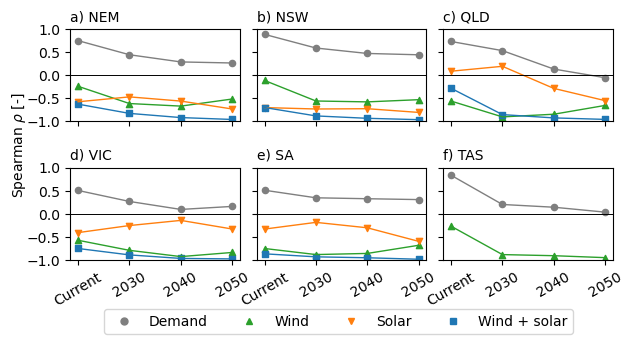

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

for i, r in enumerate(shortfall_current.region.values):
    correlations = correlate_shortfall_components(
        [shortfall_current, shortfall_SC30, shortfall_SC40, shortfall_SC50],
        [demand_current, demand_SC30, demand_SC40, demand_SC50],
        [wind_current, wind_SC30, wind_SC40, wind_SC50],
        [solar_current, solar_SC30, solar_SC40, solar_SC50],
        r)
    print(r)
    print([np.round(c, 2) for c in correlations])
    print()
    
    plot_shortfall_corr(ax.flatten()[i], correlations, r)
    
    ax.flatten()[i].set_title(letters[i] + ") " + r, loc="left", fontsize=10)

    # if i in [0]:
    #     ax.flatten()[i].set_ylabel("Absolute Spearman correlation\ncoefficient "+r"$|\rho|$")
        
    # if i == 4:
    #     ax.flatten()[i].legend(ncol=4, loc=(0, -0.4))
        
    if i > 2:
        ax.flatten()[i].set_xticklabels(["Current", "2030", "2040", "2050"], rotation=30)
    else:
        ax.flatten()[i].set_xticklabels([])
        
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_yticklabels([])
        
ax[0,0].text(-1.15, -1.5, r"Spearman $\rho$ [-]", rotation=90, ha="center", va="center")
        

# legend   
col1 = Line2D([0], [0], marker='o', linestyle="", color="tab:gray", markersize=5)
col2 = Line2D([0], [0], marker='^', linestyle="", color="tab:green", markersize=5)
col3 = Line2D([0], [0], marker='v', linestyle="", color="tab:orange", markersize=5)
col4 = Line2D([0], [0], marker='s', linestyle="", color="tab:blue", markersize=5)
# col5 = Line2D([0], [0], marker='o', linestyle="", color="k", markersize=5)
# col6 = Line2D([0], [0], marker='o', linestyle="", color="None", markeredgecolor="k", markersize=5)
labels = ["Demand", "Wind", "Solar", "Wind + solar"]#, r"$\rho>0$", r"$\rho<0$"]

plt.subplots_adjust(hspace=0.2, wspace=0.1)

ax[-1,0].legend(
    [col1, col2, col3, col4],#, col5, col6],
    labels,
    loc=(0.2, -0.8),
    ncol=4,
    frameon=True
)

plt.subplots_adjust(hspace=0.5)
# plt.suptitle("Correlation between residual load and its components", fontsize=10, y=1.1)

plt.savefig("figures/residual_load_component_corr.pdf", format="pdf", bbox_inches="tight")

#### Anomalies

In [34]:
shortfall_anoms = [anomalise_monthly(da) for da in [shortfall_current, shortfall_SC30, shortfall_SC40, shortfall_SC50]]
demand_anoms = [anomalise_monthly(da) for da in [demand_current, demand_SC30, demand_SC40, demand_SC50]]
wind_anoms = [anomalise_monthly(da) for da in [wind_current, wind_SC30, wind_SC40, wind_SC50]]
solar_anoms = [anomalise_monthly(da) for da in [solar_current, solar_SC30, solar_SC40, solar_SC50]]

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstant

Text(0.5, 1.1, 'Correlation between anomalies of residual load and its components')

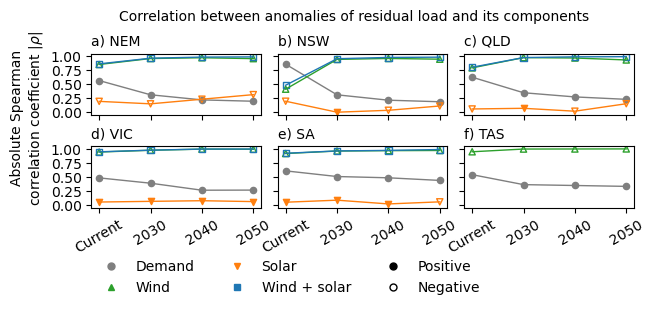

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(7,2))

for i, r in enumerate(shortfall_current.region.values):
    correlations = correlate_shortfall_components(
        shortfall_anoms,
        demand_anoms,
        wind_anoms,
        solar_anoms,
        r)
    
    plot_shortfall_corr(ax.flatten()[i], correlations, r)
    
    ax.flatten()[i].set_title(letters[i] + ") " + r, loc="left", fontsize=10)

    # if i in [0]:
    #     ax.flatten()[i].set_ylabel("Absolute Spearman correlation\ncoefficient "+r"$|\rho|$")
        
    # if i == 4:
    #     ax.flatten()[i].legend(ncol=4, loc=(0, -0.4))
        
    if i > 2:
        ax.flatten()[i].set_xticklabels(["Current", "2030", "2040", "2050"], rotation=30)
    else:
        ax.flatten()[i].set_xticklabels([])
        
    if i in [1, 2, 4, 5]:
        ax.flatten()[i].set_yticklabels([])
        
ax[0,0].text(-1.4, -0.1, "Absolute Spearman\ncorrelation coefficient "+r"$|\rho|$", rotation=90, ha="center", va="center")
        

# legend   
col1 = Line2D([0], [0], marker='o', linestyle="", color="tab:gray", markersize=5)
col2 = Line2D([0], [0], marker='^', linestyle="", color="tab:green", markersize=5)
col3 = Line2D([0], [0], marker='v', linestyle="", color="tab:orange", markersize=5)
col4 = Line2D([0], [0], marker='s', linestyle="", color="tab:blue", markersize=5)
col5 = Line2D([0], [0], marker='o', linestyle="", color="k", markersize=5)
col6 = Line2D([0], [0], marker='o', linestyle="", color="None", markeredgecolor="k", markersize=5)
labels = ["Demand", "Wind", "Solar", "Wind + solar", "Positive", "Negative"]

plt.subplots_adjust(hspace=0.2, wspace=0.1)

ax[-1,0].legend(
    [col1, col2, col3, col4, col5, col6],
    labels,
    loc=(0., -1.5),
    ncol=3,
    frameon=False
)

plt.subplots_adjust(hspace=0.5)

plt.suptitle("Correlation between anomalies of residual load and its components", fontsize=10, y=1.1)